# Introduction
- A protocol - standard
- A simple way to integrate `tools`, `resources` and `prompts`
- A USB-C port for AI applications

# Components

- `Host` is an LLM app like Claude or our Agent architecture
- `MCP Client` lives inside Host and connects 1:1 to MCP server
- `MCP Server` provides tools, context and prompts

# Architecture

- MCP Servers most often run on your box. You download open-source MCP servers, run them locally
- MCP Servers can also be remote servers as well (gaining more attraction recently)
- "Transport" mechanisms
  - `Stdio` spawns a process and communicates via standard input/output. Only for locally hosted MCP servers.
  - `SSE` uses HTTPS connections with streaming with remote servers.

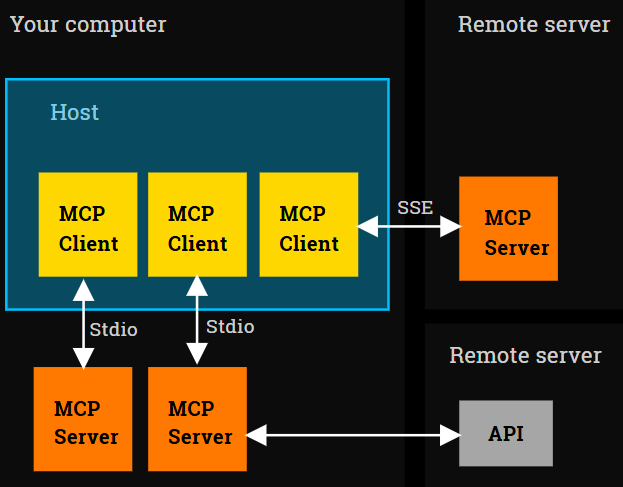

# Example - Fetching info from the internet

In [ ]:
# The imports

from dotenv import load_dotenv
from autogen_ext.tools.mcp import McpWorkbench, StdioServerParams
import os

In [ ]:
load_dotenv(override=True)

Run the MCP server in the background using below command in powershell. Background processes are not supported in Jupyter notebook.
- `!uvx mcp-server-fetch`

For some reason, below code goes into infinite loop if run in Jupyter notebook.
Refer Python script - "6-mcp-server-fetch.py".

In [ ]:


# fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])

# # Define an async function to handle the async operations
# async def get_tools():
#     async with McpWorkbench(fetch_mcp_server) as workbench:
#         return await workbench.list_tools()

# # Use IPython's built-in async support to execute the async function
# fetch_server_tools = await get_tools()
# print("Fetch server tools:", fetch_server_tools)

# Workbench

- A `Workbench` provides a collection of tools that share state and resources. 
- Different from `Tool`, which provides an interface to a single tool, a workbench provides an interface to call different tools and receive results as the same types.

# MCP Workbench

- In AutoGen, we provide `McpWorkbench` that implements an MCP client. 
- You can use it to create an agent that uses tools provided by MCP servers.

# Using Workbench

Here is an example of how to create an agent using Workbench.

In [ ]:
import json
from dataclasses import dataclass
from typing import List

from autogen_core import (
    FunctionCall,
    MessageContext,
    RoutedAgent,
    message_handler,
)
from autogen_core.model_context import ChatCompletionContext
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    FunctionExecutionResult,
    FunctionExecutionResultMessage,
    LLMMessage,
    SystemMessage,
    UserMessage,
)
from autogen_core.tools import ToolResult, Workbench


In [ ]:
@dataclass
class Message:
    content: str
    """
    A simple message container class used for communication between agents.
    
    This class represents messages sent to and from the WorkbenchAgent.
    It serves as a lightweight wrapper around string content to enable
    the message routing system within the AutoGen framework.
    
    Attributes:
        content (str): The text content of the message. This can contain
                      user queries, agent responses, or any other textual
                      information exchanged during the conversation.
    
    Usage:
        - User messages are received as Message objects by the WorkbenchAgent
        - The WorkbenchAgent returns Message objects as responses
        - The content field is processed by the agent to understand queries
          and formulate responses
    """

class WorkbenchAgent(RoutedAgent):
    """
    An agent that can use tools from a workbench to assist in responding to user queries.
    
    This agent integrates with an LLM (Large Language Model) to process user messages,
    call appropriate tools when needed, and generate helpful responses. It handles the
    full conversation flow between the user and the model, including tool execution.
    
    Attributes:
        _system_messages (List[LLMMessage]): Initial system instructions for the model
        _model_client (ChatCompletionClient): Client to interact with the language model
        _model_context (ChatCompletionContext): Stores conversation history
        _workbench (Workbench): Collection of tools the agent can use
    """
    
    def __init__(
        self, model_client: ChatCompletionClient, model_context: ChatCompletionContext, workbench: Workbench
    ) -> None:
        """
        Initialize the WorkbenchAgent with required components.
        
        Args:
            model_client: Interface to communicate with the language model
            model_context: Stores the conversation history
            workbench: Collection of tools the agent can access
        """
        super().__init__("An agent with a workbench")
        self._system_messages: List[LLMMessage] = [SystemMessage(content="You are a helpful AI assistant.")]
        self._model_client = model_client
        self._model_context = model_context
        self._workbench = workbench

    @message_handler
    async def handle_user_message(self, message: Message, ctx: MessageContext) -> Message:
        """
        Process a user message and generate a response, potentially using tools.
        
        This method:
        1. Adds the user message to the conversation history
        2. Sends the conversation to the language model
        3. If the model wants to use tools, executes them and sends results back
        4. Returns the final response to the user
        
        Args:
            message: The user's input message
            ctx: Context for handling the message, including cancellation ability
            
        Returns:
            A Message containing the agent's response
        """
        # Add the user message to the model context
        await self._model_context.add_message(UserMessage(content=message.content, source="user"))
        print("---------User Message-----------")
        print(message.content)

        # Run the initial chat completion with available tools
        create_result = await self._model_client.create(
            messages=self._system_messages + (await self._model_context.get_messages()),
            tools=(await self._workbench.list_tools()),
            cancellation_token=ctx.cancellation_token,
        )

        # Tool calling loop - continue as long as the model returns function calls
        while isinstance(create_result.content, list) and all(
            isinstance(call, FunctionCall) for call in create_result.content
        ):
            print("---------Function Calls-----------")
            for call in create_result.content:
                print(call)

            # Record the function calls in the conversation history
            await self._model_context.add_message(AssistantMessage(content=create_result.content, source="assistant"))

            # Execute each tool call and collect results
            print("---------Function Call Results-----------")
            results: List[ToolResult] = []
            for call in create_result.content:
                # Parse arguments from JSON and call the appropriate tool
                result = await self._workbench.call_tool(
                    call.name, arguments=json.loads(call.arguments), cancellation_token=ctx.cancellation_token
                )
                results.append(result)
                print(result)

            # Add the tool execution results to the conversation history
            await self._model_context.add_message(
                FunctionExecutionResultMessage(
                    content=[
                        FunctionExecutionResult(
                            call_id=call.id,
                            content=result.to_text(),
                            is_error=result.is_error,
                            name=result.name,
                        )
                        for call, result in zip(create_result.content, results, strict=False)
                    ]
                )
            )

            # Send updated conversation with tool results back to the model
            create_result = await self._model_client.create(
                messages=self._system_messages + (await self._model_context.get_messages()),
                tools=(await self._workbench.list_tools()),
                cancellation_token=ctx.cancellation_token,
            )

        # At this point, we have a text response (not more function calls)
        assert isinstance(create_result.content, str)

        print("---------Final Response-----------")
        print(create_result.content)

        # Add the final response to the conversation history
        await self._model_context.add_message(AssistantMessage(content=create_result.content, source="assistant"))

        # Return the model's response as a Message object
        return Message(content=create_result.content)


# Web Browsing Agent using Playwright MCP

You may need to install the browser dependencies for Playwright. Run in command terminal (for some reason doesn't work in Powershell)

In [ ]:
# npx playwright install chrome

Start the Playwright MCP server in a terminal.

In [ ]:
# npx @playwright/mcp@latest --port 8931

## Example 1

In [ ]:
from autogen_core import AgentId, SingleThreadedAgentRuntime
from autogen_core.model_context import BufferedChatCompletionContext
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import McpWorkbench, SseServerParams

playwright_server_params = SseServerParams(
    url="http://localhost:8931/sse",
)

# Start the workbench in a context manager.
# You can also start and stop the workbench using `workbench.start()` and `workbench.stop()`.
async with McpWorkbench(playwright_server_params) as workbench:  # type: ignore
    # Create a single-threaded agent runtime.
    runtime = SingleThreadedAgentRuntime()

    # Register the agent with the runtime.
    await WorkbenchAgent.register(
        runtime=runtime,
        type="WebAgent",
        factory=lambda: WorkbenchAgent(
            model_client=OpenAIChatCompletionClient(model="gpt-4.1-nano"),
            model_context=BufferedChatCompletionContext(buffer_size=10),
            workbench=workbench,
        ),
    )

    # Start the runtime.
    runtime.start()

    # Send a message to the agent.
    await runtime.send_message(
        Message(content="Use Bing to find out and provide the complete address of Microsoft Building 99"),
        recipient=AgentId("WebAgent", "default"),
    )

    # Stop the runtime.
    await runtime.stop()


## Example 2 - Preparing Banoffee Pie

- Check `6-mcp-preparing-banoffee-pie.py` file
- Uses browser automation using MCP servers `playwright` and `file-system`

# MCP Marketplaces

- [https://mcp.so](https://mcp.so)
- [https://glama.ai/mcp](https://glama.ai/mcp)
- [https://smithery.ai/](https://smithery.ai/)
- [https://huggingface.co/blog/LLMhacker/top-11-essential-mcp-libraries](https://huggingface.co/blog/LLMhacker/top-11-essential-mcp-libraries)
- [HuggingFace great community article](https://huggingface.co/blog/Kseniase/mcp)